# Azure Computer Vision 4 (Florence)
## Background removal with Azure Computer Vision 4

![Image](florence.jpg)

**The Image Analysis** service can divide images into multiple segments or regions to help the user identify different objects or parts of the image. **Background removal** creates an alpha matte that separates the foreground object from the background in an image.


This feature provides two possible outputs based on the customer's needs:

- The **foreground object** of the image without the background. This edited image shows the foreground object and makes the background transparent, allowing the foreground to be placed on a new background.
- An **alpha matte** that shows the opacity of the detected foreground object. This matte can be used to separate the foreground object from the background for further processing.

This service is currently in preview, and the API may change in the future.

https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/concept-background-removal

Azure Computer Vision updates: https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/whats-new#march-2023
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 3rd of May, 2023

In [1]:
import glob
import json
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from PIL import Image
from urllib.parse import urlparse

In [2]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

## Azure Computer Vision 4.0

In [3]:
load_dotenv("azure.env")

key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [4]:
url = endpoint + "/computervision/imageanalysis:segment?api-version=2023-02-01-preview"
background_removal = "&mode=backgroundRemoval"
foreground_matting = "&mode=foregroundMatting"

remove_background_url = url + background_removal  # For removing the background
get_mask_object_url = url + foreground_matting  # Mask of the object

headers = {"Content-type": "application/json", 
           "Ocp-Apim-Subscription-Key": key}

## Functions

In [5]:
IMAGES_DIR = "images"

In [6]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [7]:
def remove_background(image_url):
    """
    Removing background
    """
    image = {"url": image_url}
    r = requests.post(remove_background_url, data=json.dumps(image), headers=headers)

    object_image = os.path.join(
        RESULTS_DIR, "object_" + os.path.basename(urlparse(image_url).path)
    )

    with open(object_image, "wb") as f:
        f.write(r.content)

    return Image.open(object_image)

In [8]:
def get_mask(image_url):
    """
    Get Mask
    """
    image = {"url": image_url}
    r = requests.post(get_mask_object_url, data=json.dumps(image), headers=headers)

    mask_image = os.path.join(
        RESULTS_DIR, "mask_" + os.path.basename(urlparse(image_url).path)
    )

    with open(mask_image, "wb") as f:
        f.write(r.content)

    return Image.open(mask_image)

In [9]:
def get_stats(image):
    """
    Pixel stats on mask image
    """
    image = image.convert("L")
    width, height = image.size
    total_pixels = width * height
    black_pixels = 0

    for x in range(width):
        for y in range(height):
            if image.getpixel((x, y)) == 0:
                black_pixels += 1

    white_pixels = total_pixels - black_pixels
    pct_whitepixels = white_pixels / total_pixels
    pct_blackpixels = black_pixels / total_pixels

    print("Number of pixels:", "{:,}".format(total_pixels))
    print(
        "\nNumber of black pixels:",
        "{:,}".format(black_pixels),
        f"{pct_blackpixels:.2%}",
    )
    print(
        "Number of white pixels:", "{:,}".format(white_pixels), f"{pct_whitepixels:.2%}"
    )

## Test 1

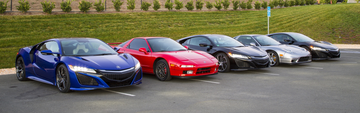

In [10]:
image_url = "https://github.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/blob/main/images/cars.jpg?raw=true"

r = requests.get(image_url)
img = Image.open(BytesIO(r.content))
img.thumbnail((360, 360), Image.Resampling.LANCZOS)
img

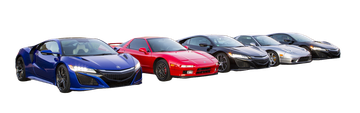

In [11]:
remove_background_img = remove_background(image_url)

remove_background_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
remove_background_img

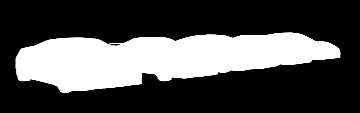

In [12]:
get_mask_img = get_mask(image_url)

get_mask_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
get_mask_img

In [13]:
get_stats(get_mask_img)

Number of pixels: 40,680

Number of black pixels: 28,140 69.17%
Number of white pixels: 12,540 30.83%


## Test 2

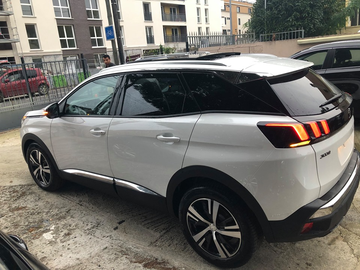

In [14]:
image_url = "https://github.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/blob/main/images/whitecar.jpg?raw=true"

r = requests.get(image_url)
img = Image.open(BytesIO(r.content))
img.thumbnail((360, 360), Image.Resampling.LANCZOS)
img

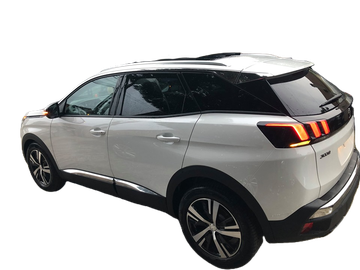

In [15]:
remove_background_img = remove_background(image_url)

remove_background_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
remove_background_img

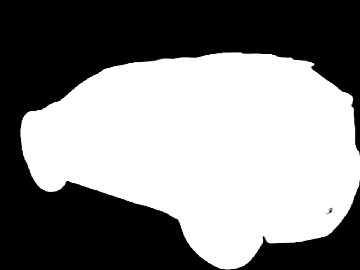

In [16]:
get_mask_img = get_mask(image_url)

get_mask_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
get_mask_img

In [17]:
get_stats(get_mask_img)

Number of pixels: 97,200

Number of black pixels: 46,225 47.56%
Number of white pixels: 50,975 52.44%


## Test 3

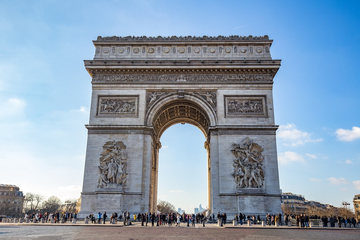

In [18]:
image_url = "https://github.com/retkowsky/Azure-Computer-Vision-in-a-day-workshop/blob/main/images/arc_triomphe.jpg?raw=true"

r = requests.get(image_url)
img = Image.open(BytesIO(r.content))
img.thumbnail((360, 360), Image.Resampling.LANCZOS)
img

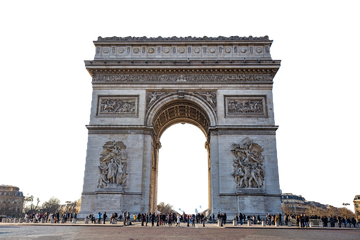

In [19]:
remove_background_img = remove_background(image_url)

remove_background_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
remove_background_img

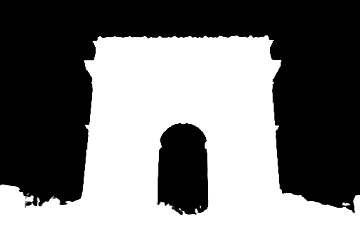

In [20]:
get_mask_img = get_mask(image_url)

get_mask_img.thumbnail((360, 360), Image.Resampling.LANCZOS)
get_mask_img

In [21]:
get_stats(get_mask_img)

Number of pixels: 86,400

Number of black pixels: 44,735 51.78%
Number of white pixels: 41,665 48.22%


## Using a local image

In [22]:
image_file = os.path.join(IMAGES_DIR, "car.jpg")
new_backgroundfile = os.path.join(IMAGES_DIR, "sand.jpg")

initial_image = Image.open(image_file)
new_background = Image.open(new_backgroundfile)

print(img.size, new_background.size)

(360, 240) (1600, 1200)


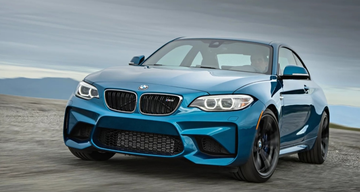

In [23]:
initial_image.thumbnail((360, 360), Image.Resampling.LANCZOS)
initial_image

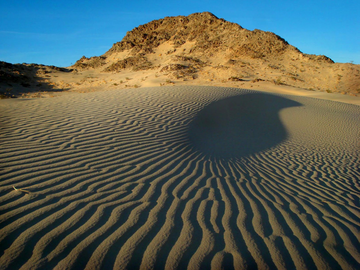

In [24]:
new_background.thumbnail((360, 360), Image.Resampling.LANCZOS)
new_background

In [25]:
# Need to resize the image (both images should have the same size)
new_background = new_background.resize(initial_image.size)

print(initial_image.size, new_background.size)

(360, 192) (360, 192)


In [26]:
(file, ext) = os.path.splitext(os.path.basename(image_file))

without_background_file = RESULTS_DIR + "/" + file + "_without_background" + ext
mask_file = RESULTS_DIR + "/" + file + "_mask" + ext

with open(image_file, "rb") as f:
    data = f.read()

headers = {"Content-type": "application/octet-stream", "Ocp-Apim-Subscription-Key": key}

# Remove background
r = requests.post(remove_background_url, data=data, headers=headers)

with open(without_background_file, "wb") as f:
    f.write(r.content)

# Mask
r = requests.post(get_mask_object_url, data=data, headers=headers)

with open(mask_file, "wb") as f:
    f.write(r.content)

In [27]:
without_background = Image.open(without_background_file)
without_background.thumbnail((360, 360), Image.Resampling.LANCZOS)

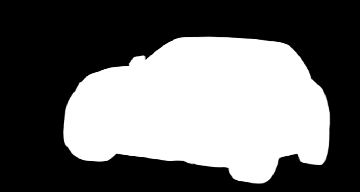

In [28]:
mask = Image.open(mask_file)
mask.thumbnail((360, 360), Image.Resampling.LANCZOS)
mask

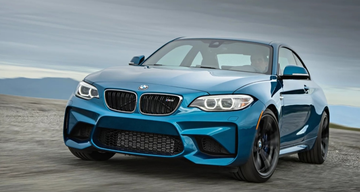

In [29]:
# Initial image
initial_image.thumbnail((360, 360), Image.Resampling.LANCZOS)
initial_image

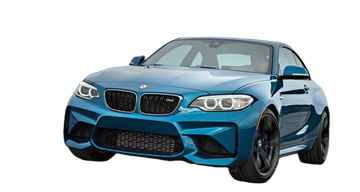

In [30]:
without_background

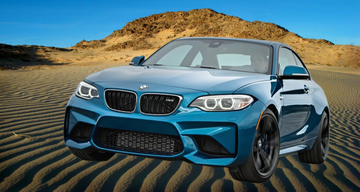

In [31]:
# New image with a different background
new_background.paste(without_background, (0, 0), without_background)
new_background.thumbnail((360, 360), Image.Resampling.LANCZOS)
new_background

## Batch

In [32]:
images = [
    file
    for file in glob.glob(IMAGES_DIR + "/*.*")
    if file.endswith(("jpeg", "png", "jpg", "JPG", "JPEG", "PNG"))
]
images

['images/businesscard.jpg',
 'images/car.jpg',
 'images/car.png',
 'images/car2.jpg',
 'images/cat.jpg',
 'images/drinks.jpg',
 'images/fashionprocess.png',
 'images/fruits.jpg',
 'images/image1.jpg',
 'images/office.jpg',
 'images/postalcard.jpg',
 'images/presentation.png',
 'images/sand.jpg',
 'images/street.jpg',
 'images/tomato.jpg']

In [33]:
nb = 1

headers = {
    "Content-type": "application/octet-stream",
     "Ocp-Apim-Subscription-Key": key,
}
    
for image in images:
    print(nb, "Processing image:", image)

    (file, ext) = os.path.splitext(os.path.basename(image))
    without_background_file = RESULTS_DIR + "/" + file + "_without_background" + ext
    mask_file = RESULTS_DIR + "/" + file + "_mask" + ext

    with open(image, "rb") as f:
        data = f.read()

    # Remove background
    r = requests.post(remove_background_url, data=data, headers=headers)
    with open(without_background_file, "wb") as f:
        f.write(r.content)

    # Mask
    r = requests.post(get_mask_object_url, data=data, headers=headers)
    with open(mask_file, "wb") as f:
        f.write(r.content)

    nb += 1

print("\nDone")
print("Number of processed images =", nb - 1)

1 Processing image: images/businesscard.jpg
2 Processing image: images/car.jpg
3 Processing image: images/car.png
4 Processing image: images/car2.jpg
5 Processing image: images/cat.jpg
6 Processing image: images/drinks.jpg
7 Processing image: images/fashionprocess.png
8 Processing image: images/fruits.jpg
9 Processing image: images/image1.jpg
10 Processing image: images/office.jpg
11 Processing image: images/postalcard.jpg
12 Processing image: images/presentation.png
13 Processing image: images/sand.jpg
14 Processing image: images/street.jpg
15 Processing image: images/tomato.jpg

Done
Number of processed images = 15


In [36]:
results_image_files = [
    file
    for file in glob.glob(RESULTS_DIR + "/*.*")
    if file.endswith(("jpeg", "png", "jpg"))
]

filtered_file_names = [
    file_name
    for file_name in results_image_files
    if "mask" in file_name or "without_background" in file_name
]

filtered_file_names

['results/businesscard_mask.jpg',
 'results/businesscard_without_background.jpg',
 'results/car2_mask.jpg',
 'results/car2_without_background.jpg',
 'results/car_mask.jpg',
 'results/car_mask.png',
 'results/car_without_background.jpg',
 'results/car_without_background.png',
 'results/cat_mask.jpg',
 'results/cat_without_background.jpg',
 'results/drinks_mask.jpg',
 'results/drinks_without_background.jpg',
 'results/fashionprocess_mask.png',
 'results/fashionprocess_without_background.png',
 'results/fruits_mask.jpg',
 'results/fruits_without_background.jpg',
 'results/image1_mask.jpg',
 'results/image1_without_background.jpg',
 'results/mask_arc_triomphe.jpg',
 'results/mask_cars.jpg',
 'results/mask_whitecar.jpg',
 'results/office_mask.jpg',
 'results/office_without_background.jpg',
 'results/postalcard_mask.jpg',
 'results/postalcard_without_background.jpg',
 'results/presentation_mask.png',
 'results/presentation_without_background.png',
 'results/sand_mask.jpg',
 'results/sand_wit

<IPython.core.display.Javascript object>